In [1]:
import geopandas as gpd
import lxml
import missingno as msno
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString, MultiLineString

from urbana.constants import DIR_DATA
from urbana.data.datasets import merge_datasets
from urbana.data.geo import harversine_distance_btw_geoseries_point

SCL_PATH = DIR_DATA / "external" / "scl"
CENSUS_PATH = SCL_PATH / "census"
URBAN_AREAS_PATH = SCL_PATH / "urban_areas"
PATH_R13 = SCL_PATH /  "R13"

<Axes: >

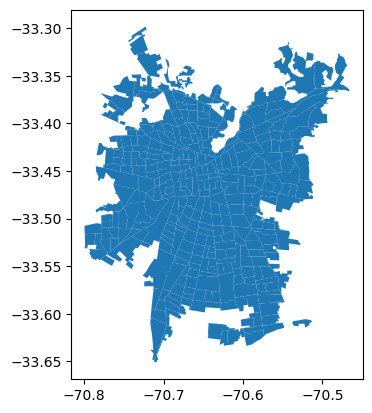

In [2]:
urban_districts = gpd.read_file(SCL_PATH / 'urban_districts')
urban_districts.plot()

In [3]:
OSM_PATH = SCL_PATH / "OSM"

osm_clipped_file = OSM_PATH / 'clipped-scl-osm.pbf'

if not osm_clipped_file.exists():
    import os
    bounds = urban_districts.total_bounds
    print(bounds)
    print(f"osmconvert {OSM_PATH / 'chile-latest.osm.pbf'} -b={bounds[0]},{bounds[1]},{bounds[2]},{bounds[3]} -o={osm_clipped_file}")
    os.system(f"osmconvert {OSM_PATH / 'chile-latest.osm.pbf'} -b={bounds[0]},{bounds[1]},{bounds[2]},{bounds[3]} -o={osm_clipped_file}")
else:
    print('data already available :D')

import pyrosm
osm = pyrosm.OSM(str(osm_clipped_file))
scl_pois = osm.get_pois().to_crs(urban_districts.crs)
scl_pois = scl_pois[~(scl_pois["lat"].isna() | scl_pois["lon"].isna())] # eliminamos aquellos que no tienen lat y/o lon

data already available :D


In [4]:
census = (pd.read_csv(CENSUS_PATH / 'Censo2017_Manzanas.csv', sep=';')
          .merge(pd.read_csv(CENSUS_PATH / 'Censo2017_Identificación_Geográfica' / 'Microdato_Censo2017-Urbano.csv', sep=';'))
          .pipe(lambda x: x[x.REGION == 13])
          .drop('ZONA', axis=1)
          .drop_duplicates()
         )
count_columns = ['HOMBRES', 'MUJERES','EDAD_0A5', 'EDAD_6A14', 'EDAD_15A64', 'EDAD_65YMAS', 
                 'INMIGRANTES', 'PUEBLO', 'VIV_PART', 'VIV_COL']
for col in count_columns:
    census[col] = census[col].replace('*', 0).astype(int)

# agregando medidas relativas de población
census["POBLACION"] = census["HOMBRES"] + census["MUJERES"]

census["MUJERES_%"] = census["MUJERES"] / (census["POBLACION"])
census["HOMBRES_%"] = census["HOMBRES"] / (census["POBLACION"])

age_columns = census.columns[census.columns.str.contains("EDAD")]
for c in age_columns:
    census[c + "_%"] = census[c] / census["POBLACION"]

columns_to_add = [
    'INMIGRANTES', 'PUEBLO', 'VIV_PART', 'VIV_COL', 
    'POBLACION', 'MUJERES_%', 'HOMBRES_%', 'EDAD_0A5_%', 
    'EDAD_6A14_%', 'EDAD_15A64_%', 'EDAD_65YMAS_%'
]

dc_values = census.groupby(['REGION', 'PROVINCIA', 'COMUNA', 'DC'])[columns_to_add].sum().reset_index().rename(columns={'DC': 'COD_DISTRI'})

dc_values = dc_values.rename(
    columns={
        'PUEBLO': 'PUEBLO_ORIGINARIO_INDIGENA',
        'VIV_PART': 'VIVIENDAS_PARTITUCLARES',
        'VIV_COL': 'VIVIENDAS_COLECTIVAS'
    }
)


In [5]:
sect = urban_districts.merge(dc_values, how='inner')
print(sect.shape)
sect.head()

(342, 20)


,REGION,PROVINCIA,COMUNA,COD_DISTRI,DESC_REGIO,DESC_PROVI,DESC_COMUN,DESC_DISTR,geometry,INMIGRANTES,PUEBLO_ORIGINARIO_INDIGENA,VIVIENDAS_PARTITUCLARES,VIVIENDAS_COLECTIVAS,POBLACION,MUJERES_%,HOMBRES_%,EDAD_0A5_%,EDAD_6A14_%,EDAD_15A64_%,EDAD_65YMAS_%
0,13,131,13114,4,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,LAS CONDES,"POLYGON ((-70.48101 -33.36476, -70.48127 -33.3...",1487,462,5391,7,16118,47.394800,39.605200,4.179029,7.565507,56.925727,13.394499
1,13,131,13114,15,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,SAN CARLOS DE APOQUINDO,"POLYGON ((-70.49823 -33.38107, -70.49937 -33.3...",1632,261,4155,3,17160,63.296735,57.703265,5.232115,15.618947,86.645838,6.421456
2,13,131,13114,16,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,CERRO CALÁN,"POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...",1180,354,4458,8,14591,46.248580,40.751420,2.855940,6.236287,58.869579,13.377641
3,13,131,13114,2,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,ESTADIO PALESTINO,"POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...",1632,417,6394,1,14323,42.306269,36.693731,3.780500,4.306763,50.924501,12.174854
4,13,131,13114,3,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,HOSPITAL FACH,"POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...",2716,451,9691,8,19597,68.154644,59.845356,4.825977,6.773109,85.995763,20.904411


In [6]:
# agregando distancia al centro
PALACIO_DE_LA_MONEDA = Point(-70.65387, -33.443018)
d_haversine = harversine_distance_btw_geoseries_point(
    sect["geometry"].centroid, PALACIO_DE_LA_MONEDA
).to_frame("Distance_to_Center")
sect = merge_datasets(sect, d_haversine)
sect

/tmp/ipykernel_208356/3427580960.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sect["geometry"].centroid, PALACIO_DE_LA_MONEDA


,REGION,PROVINCIA,COMUNA,COD_DISTRI,DESC_REGIO,DESC_PROVI,DESC_COMUN,DESC_DISTR,geometry,INMIGRANTES,...,VIVIENDAS_PARTITUCLARES,VIVIENDAS_COLECTIVAS,POBLACION,MUJERES_%,HOMBRES_%,EDAD_0A5_%,EDAD_6A14_%,EDAD_15A64_%,EDAD_65YMAS_%,Distance_to_Center
0,13,131,13114,4,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,LAS CONDES,"POLYGON ((-70.48101 -33.36476, -70.48127 -33.3...",1487,...,5391,7,16118,47.394800,39.605200,4.179029,7.565507,56.925727,13.394499,14.789013
1,13,131,13114,15,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,SAN CARLOS DE APOQUINDO,"POLYGON ((-70.49823 -33.38107, -70.49937 -33.3...",1632,...,4155,3,17160,63.296735,57.703265,5.232115,15.618947,86.645838,6.421456,14.821569
2,13,131,13114,16,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,CERRO CALÁN,"POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...",1180,...,4458,8,14591,46.248580,40.751420,2.855940,6.236287,58.869579,13.377641,12.530262
3,13,131,13114,2,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,ESTADIO PALESTINO,"POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...",1632,...,6394,1,14323,42.306269,36.693731,3.780500,4.306763,50.924501,12.174854,10.856379
4,13,131,13114,3,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,HOSPITAL FACH,"POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...",2716,...,9691,8,19597,68.154644,59.845356,4.825977,6.773109,85.995763,20.904411,10.155002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,13,134,13401,7,REGIÓN METROPOLITANA DE SANTIAGO,MAIPO,SAN BERNARDO,MAESTRANZA,"MULTIPOLYGON (((-70.69203 -33.60014, -70.69268...",165,...,4096,1,11681,29.615898,27.384102,4.496776,7.638151,40.297178,1.625781,18.592924
338,13,134,13401,14,REGIÓN METROPOLITANA DE SANTIAGO,MAIPO,SAN BERNARDO,LOS MORROS,"POLYGON ((-70.69306 -33.61304, -70.68962 -33.6...",501,...,8948,3,29730,97.735316,94.264684,14.582279,25.686517,128.712848,10.300865,20.771023
339,13,133,13301,3,REGIÓN METROPOLITANA DE SANTIAGO,CHACABUCO,COLINA,ALGARROBAL,"POLYGON ((-70.72257 -33.29815, -70.72153 -33.3...",1137,...,3933,12,13353,59.196856,60.803144,inf,18.400887,inf,5.278772,16.900251
340,13,133,13302,4,REGIÓN METROPOLITANA DE SANTIAGO,CHACABUCO,LAMPA,LA VILANA,"POLYGON ((-70.73333 -33.32757, -70.73456 -33.3...",2757,...,24279,15,65472,196.747863,199.252137,40.786693,45.246687,inf,7.114881,15.778260


In [7]:
# import shapely.wkt
linea_1 = gpd.read_file(SCL_PATH / "Linea_1_metro.geojson")["geometry"]
connected = MultiLineString(list(linea_1))
sect['Distance_to_Linea_1'] = sect['geometry'].apply(lambda g: connected.distance(g.centroid))
linea_1

0     LINESTRING (-70.62172 -33.42969, -70.62220 -33...
1     LINESTRING (-70.71944 -33.45673, -70.72021 -33...
2     LINESTRING (-70.72270 -33.45105, -70.72280 -33...
3     LINESTRING (-70.72286 -33.44859, -70.72311 -33...
4     LINESTRING (-70.71631 -33.45734, -70.71944 -33...
5     LINESTRING (-70.66048 -33.44619, -70.66102 -33...
6     LINESTRING (-70.58474 -33.41430, -70.58502 -33...
7     LINESTRING (-70.54501 -33.40790, -70.54669 -33...
8     LINESTRING (-70.58462 -33.41425, -70.58474 -33...
9     LINESTRING (-70.71363 -33.45786, -70.71546 -33...
10    LINESTRING (-70.71623 -33.45736, -70.71631 -33...
Name: geometry, dtype: geometry

In [8]:
count_columns = ['religion', 'shop', 'tourism', 'museum', 'id']
pois_with_districts = gpd.sjoin(urban_districts, scl_pois)
for c in count_columns:
    pois_with_districts[c] = pois_with_districts[c].apply(lambda x: 0 if x == None else 1)
# print(pois_with_districts)

tags_regex = {
    "bank": 'bank', 
    "healthcare": "clinic|dentist|hospital",
    "food": "cuisine|food|restaurant",
    "education": "school|colegio|escuela|university",
    "pharmacy": "farmacia|pharmacy",
    "artwork": "artwork"
}

pois_columns = count_columns + list(tags_regex.keys())

pois_counted = pois_with_districts.groupby(['REGION', 'PROVINCIA', 'COMUNA', 'COD_DISTRI'])[count_columns].sum().reset_index().drop(['REGION', 'PROVINCIA', 'COMUNA', 'COD_DISTRI'], axis=1)
# print(pois_with_districts.index)
for index in pois_with_districts.index.drop_duplicates().tolist():
    pois_in_district = pois_with_districts.loc[index, "tags"]
    # print(type(pois_in_district))
    if(type(pois_in_district) != type(None)):
        for tag in tags_regex.keys():
            if(type(pois_in_district) == str):
                if(pois_in_district.__contains__(tag)):
                    pois_counted.loc[index, tag] = 1
            else:
                n = len(pois_in_district[pois_in_district.str.contains(tags_regex[tag]).fillna(False)])
                pois_counted.loc[index, tag] = n

pois_counted.rename(columns={'id': 'total_pois'}, inplace=True)
for c in pois_columns:
    pois_counted.rename(columns={c: c + "_pois_count"}, inplace=True)
pois_counted = pois_counted.fillna(0)
pois_counted[pois_counted.columns].astype(np.int32)
sect = merge_datasets(sect, pois_counted)

In [9]:
sect

,REGION,PROVINCIA,COMUNA,COD_DISTRI,DESC_REGIO,DESC_PROVI,DESC_COMUN,DESC_DISTR,geometry,INMIGRANTES,...,shop_pois_count,tourism_pois_count,museum_pois_count,total_pois,bank_pois_count,healthcare_pois_count,food_pois_count,education_pois_count,pharmacy_pois_count,artwork_pois_count
0,13,131,13114,4,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,LAS CONDES,"POLYGON ((-70.48101 -33.36476, -70.48127 -33.3...",1487,...,80.0,78.0,4.0,445.0,0.0,2.0,14.0,4.0,5.0,0.0
1,13,131,13114,15,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,SAN CARLOS DE APOQUINDO,"POLYGON ((-70.49823 -33.38107, -70.49937 -33.3...",1632,...,316.0,47.0,5.0,904.0,0.0,0.0,17.0,0.0,5.0,1.0
2,13,131,13114,16,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,CERRO CALÁN,"POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...",1180,...,54.0,8.0,0.0,135.0,0.0,0.0,4.0,3.0,0.0,0.0
3,13,131,13114,2,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,ESTADIO PALESTINO,"POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...",1632,...,58.0,15.0,0.0,351.0,1.0,0.0,14.0,1.0,2.0,0.0
4,13,131,13114,3,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,HOSPITAL FACH,"POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...",2716,...,47.0,4.0,0.0,128.0,0.0,0.0,18.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,13,134,13401,7,REGIÓN METROPOLITANA DE SANTIAGO,MAIPO,SAN BERNARDO,MAESTRANZA,"MULTIPOLYGON (((-70.69203 -33.60014, -70.69268...",165,...,1.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
338,13,134,13401,14,REGIÓN METROPOLITANA DE SANTIAGO,MAIPO,SAN BERNARDO,LOS MORROS,"POLYGON ((-70.69306 -33.61304, -70.68962 -33.6...",501,...,0.0,0.0,0.0,13.0,0.0,0.0,0.0,3.0,0.0,0.0
339,13,133,13301,3,REGIÓN METROPOLITANA DE SANTIAGO,CHACABUCO,COLINA,ALGARROBAL,"POLYGON ((-70.72257 -33.29815, -70.72153 -33.3...",1137,...,1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
340,13,133,13302,4,REGIÓN METROPOLITANA DE SANTIAGO,CHACABUCO,LAMPA,LA VILANA,"POLYGON ((-70.73333 -33.32757, -70.73456 -33.3...",2757,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<Axes: >

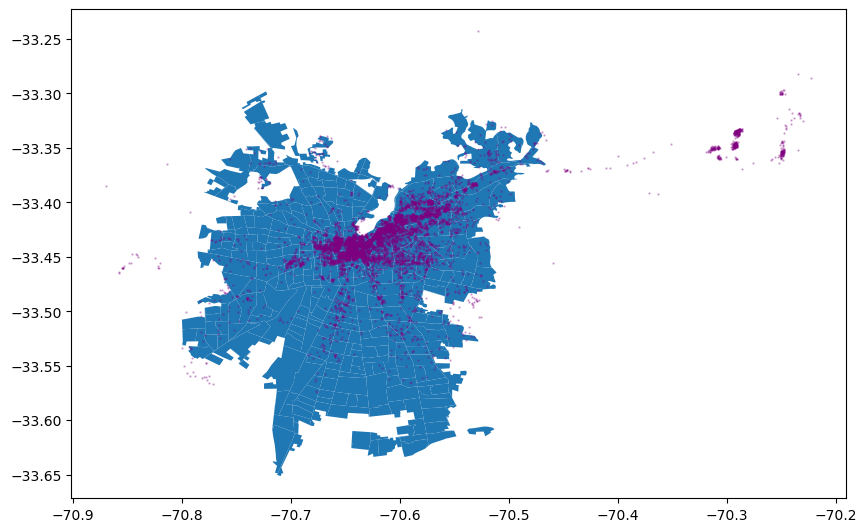

In [10]:
inside_airbnb = (
    pd.read_csv(SCL_PATH / "29-03-2023-insideAirBnB.csv")
)
inside_airbnb["price"] = inside_airbnb["price"].apply(lambda x: int(x[1:-3].replace(",", '')))
inside_airbnb["per_person_price"] = inside_airbnb["price"].div(inside_airbnb["accommodates"])
inside_airbnb["rating"] = inside_airbnb["review_scores_location"].astype("float")
# inside_airbnb["rating"]
gdf = gpd.GeoDataFrame(
    data=inside_airbnb.drop(
        list(inside_airbnb.columns[
            (inside_airbnb.columns.str.contains("host|availability|url|nights|calendar|scrap|description|neighbourhood|book|bath|amenities|license|review"))
            ]), axis=1), 
                       geometry=gpd.points_from_xy(inside_airbnb['longitude'], inside_airbnb["latitude"]))
ax = urban_districts.plot(figsize=(10,10))
gdf.plot(ax=ax, color="purple", markersize=0.5, alpha=0.3)

In [11]:
# tagging by section
# Set the column for the tags
gdf["Tag"] = -1

# Classify the Airbnbs based on their location
for i in range(len(sect.index)):
    selection = gdf["geometry"].within(sect["geometry"][i])
    selection_index = selection[selection].index
    gdf.loc[selection_index, "Tag"] = sect.index[i]

#removing out of zone airbnbs
gdf = gdf[gdf["Tag"] != -1]     

counts = (
    gdf["Tag"].value_counts().rename("Airbnb_Count").sort_index().to_frame()
)


prices = (
    gdf.groupby(["Tag"])["price"].agg("mean").rename("Airbnb_Price").sort_index()
).to_frame()

per_person_prices = (
    gdf.groupby(["Tag"])["per_person_price"]
    .agg("mean")
    .rename("Airbnb_Per_Person_Price")
    .sort_index()
).to_frame()

ratings = (
    gdf.groupby(["Tag"])["rating"]
    .agg("mean")
    .rename("Airbnb_Location_Rating")
    .sort_index()
).to_frame()

sect = merge_datasets(sect, counts)
sect = merge_datasets(sect, prices)
sect = merge_datasets(sect, per_person_prices)
sect = merge_datasets(sect, ratings)
sect.fillna(0, inplace=True)

# Saving the data

In [12]:
OUTPUT_PATH = SCL_PATH / "output"

# from shapely.geometry import mapping, Polygon, MultiPolygon

# def flip_coordinates(geometry):
#     t = geometry.geom_type
#     if(t == 'Polygon'):
#         boundry = list(geometry.exterior.coords)
#         reversed = [Point(x[0], x[1]) for x in boundry]
#         return Polygon(reversed)
    
#     elif(t == 'MultiPolygon'):
#         geoms = list(geometry.geoms)
#         reversed_geoms = [flip_coordinates(polygon) for polygon in geoms]
#         return MultiPolygon(reversed_geoms)
    
# sect_reversed = gpd.GeoDataFrame(data=list(sect.index)  ,geometry=urban_districts["geometry"].apply(flip_coordinates), crs=urban_districts.crs)
# # sect_reversed = sect_reversed.rename(columns={'0': "Tag"})

sect["geometry"] = sect["geometry"].apply(str)

/tmp/ipykernel_208356/297495858.py:20: UserWarning: Geometry column does not contain geometry.
  sect["geometry"] = sect["geometry"].apply(str)


In [13]:
sect.to_csv(OUTPUT_PATH / "census_processed.csv")
# sect.to_json(OUTPUT_PATH / "census_processed.json")

<Axes: >

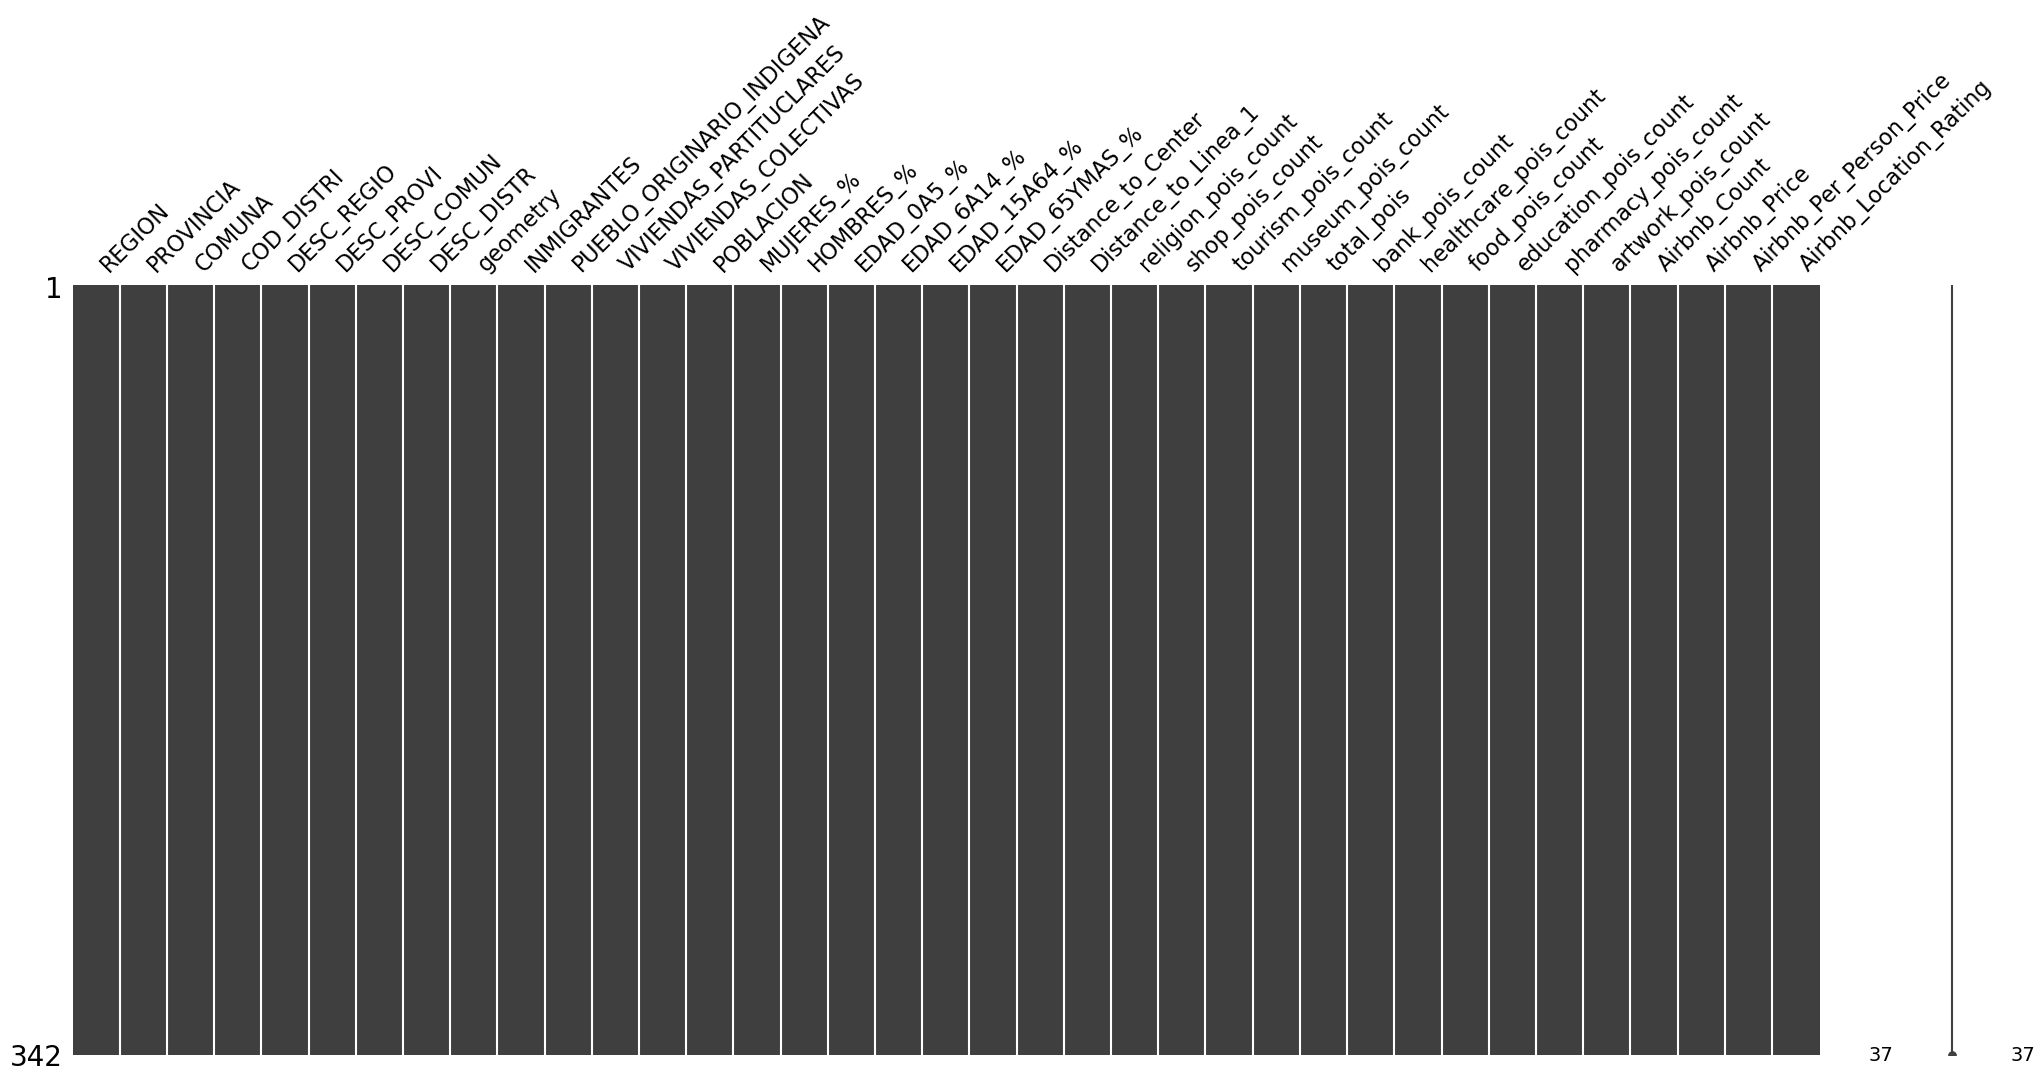

In [14]:
# print(sect.columns)
msno.matrix(sect)